<a href="https://colab.research.google.com/github/LimJongYoon/2020MLP/blob/master/06_lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


In [56]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [59]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00990.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06450.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04530.png')]

In [60]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010020_P.png')]

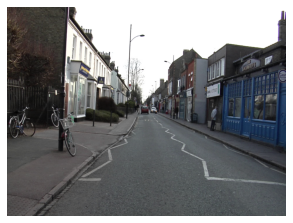

In [61]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

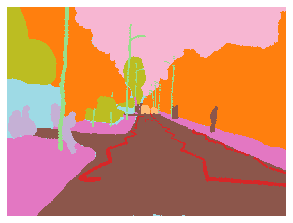

In [63]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
#색상별로 데이터 분류한것

In [64]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [65]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=8
#else:           bs=4
#print(f"using bs={bs}, have {free}MB of GPU RAM free")
#bs=32
bs=8
 

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

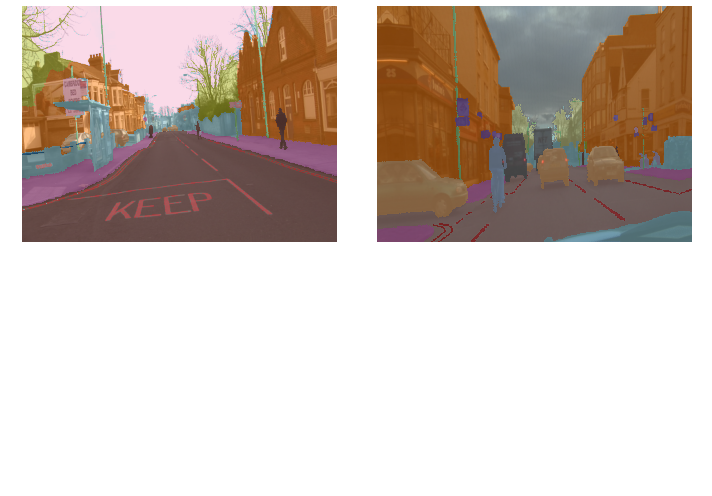

In [107]:
data.show_batch(2, figsize=(10,7))

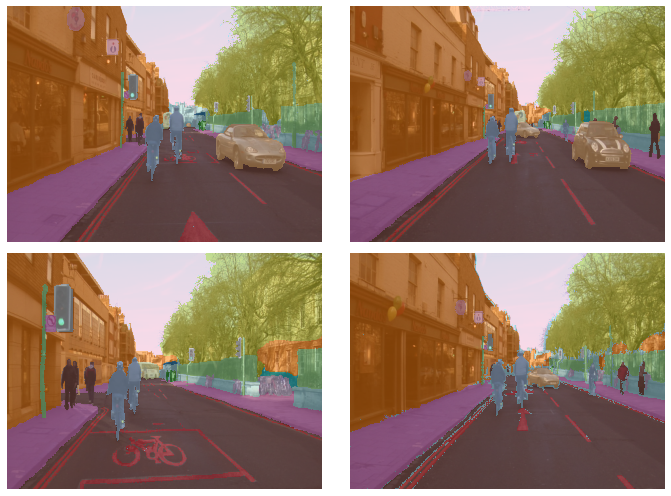

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


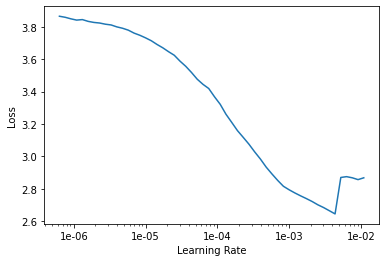

In [28]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.237606,0.834668,0.814264,00:58
1,0.845194,0.660586,0.831104,00:54
2,0.708764,0.550053,0.855560,00:55
3,0.620108,0.520904,0.853124,00:55
4,0.618458,0.499257,0.863688,00:54
5,0.588173,0.561023,0.859017,00:53
6,0.627022,0.534379,0.861025,00:53
7,0.554024,0.430296,0.880358,00:53
8,0.511513,0.404746,0.885940,00:53
9,0.447767,0.329524,0.907008,00:53


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

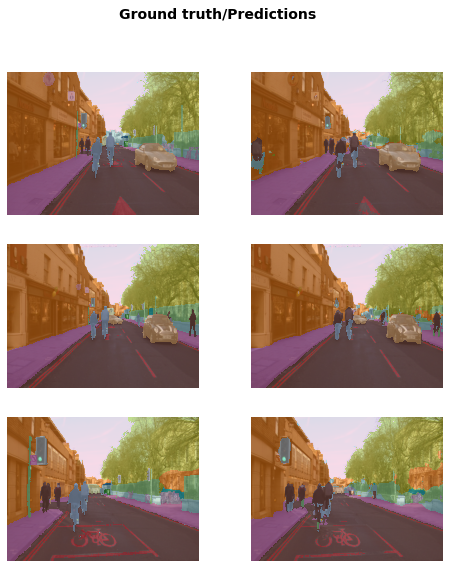

In [33]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [36]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.383891,0.326949,0.906610,00:55
1,0.370971,0.319640,0.909519,00:55
2,0.363869,0.314293,0.911971,00:55
3,0.357108,0.294374,0.918417,00:55
4,0.347017,0.306270,0.913843,00:55
5,0.334210,0.298350,0.916679,00:55
6,0.338359,0.284788,0.922675,00:55
7,0.323189,0.313065,0.910309,00:55
8,0.306031,0.278095,0.923651,00:54
9,0.296653,0.305421,0.912645,00:54


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [38]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


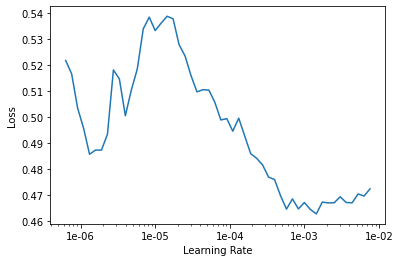

In [42]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [44]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) #가끔씩 읽다가 팅기는 현상 발생 왜 이러는건지..

epoch,train_loss,valid_loss,acc_camvid,time
0,0.382052,0.319284,0.911957,03:38
1,0.342216,0.343265,0.907160,03:35
2,0.326078,0.302982,0.915308,03:35
3,0.332449,0.278984,0.920087,03:35
4,0.343666,0.315449,0.913488,03:35
5,0.352243,0.312571,0.918558,03:35
6,0.312634,0.311133,0.915905,03:35
7,0.305760,0.286267,0.922895,03:35
8,0.282233,0.268414,0.925424,03:36
9,0.230140,0.254321,0.928642,03:36


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [49]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.214964,0.249580,0.929868,03:43
1,0.217800,0.246592,0.931534,03:42
2,0.212557,0.243347,0.930792,03:42
3,0.208236,0.241304,0.932074,03:42
4,0.207496,0.251257,0.929470,03:43
5,0.204172,0.244165,0.930886,03:42
6,0.193519,0.240676,0.931346,03:42
7,0.194810,0.241710,0.931226,03:42
8,0.189702,0.242441,0.931850,03:43
9,0.191842,0.239825,0.932114,03:43


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

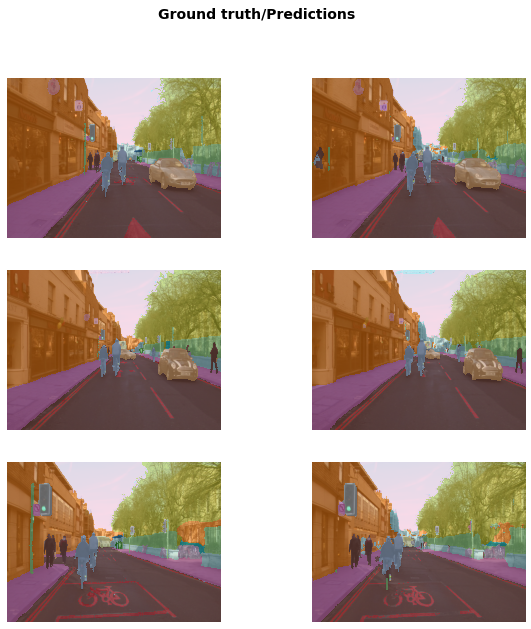

In [52]:
learn.show_results(rows=3, figsize=(10,10))

## fin